In [3]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install jupyterlab
!pip install scipy
!pip install statsmodels
!pip install plotly
!pip install tensorflow
!pip install keras
!pip install xgboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 24.8 MB/s  0:00:00m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 32.5 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 24.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 34.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 34.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 22.3 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 35.4 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 23.5 MB/s  0:00:00m0:00:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [5]:
# Load CSV
df = pd.read_csv("/workspaces/Generative-AI/Nat_Gas.csv")

# Ensure proper column names
df.columns = ["date", "price"]

# Convert to datetime
df["date"] = pd.to_datetime(df["date"])

# Sort chronologically
df = df.sort_values("date").reset_index(drop=True)

df.head()


/tmp/ipykernel_4787/2528079659.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"])


,date,price
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


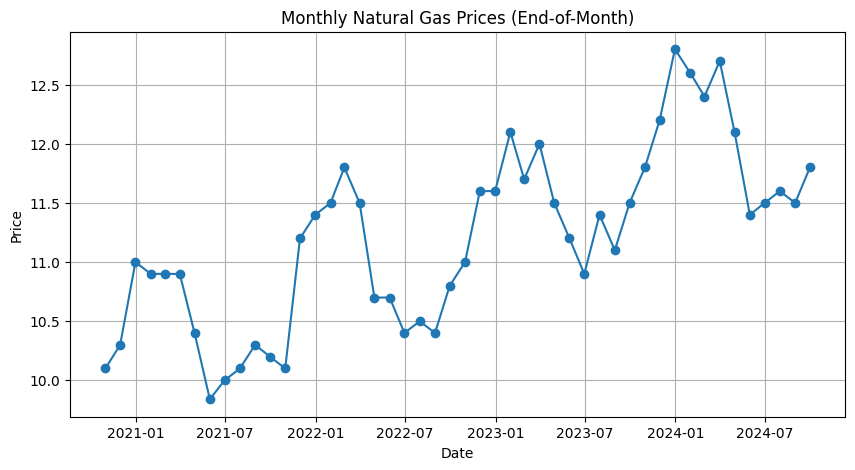

In [6]:
plt.figure(figsize=(10,5))
plt.plot(df["date"], df["price"], marker="o")
plt.title("Monthly Natural Gas Prices (End-of-Month)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


In [7]:
df["month"] = df["date"].dt.month

monthly_avg = df.groupby("month")["price"].mean()
overall_avg = df["price"].mean()

seasonality = monthly_avg - overall_avg


In [8]:
df["deseasonal_price"] = df.apply(
    lambda row: row["price"] - seasonality[row["month"]],
    axis=1
)


In [9]:
start_date = df["date"].min()
df["t"] = (df["date"] - start_date).dt.days

trend_function = interp1d(
    df["t"],
    df["deseasonal_price"],
    kind="linear",
    fill_value="extrapolate"
)


In [10]:
def estimate_gas_price(input_date):
    """
    Returns estimated natural gas price for any past date
    and extrapolates up to 1 year into the future.
    """
    if isinstance(input_date, str):
        input_date = pd.to_datetime(input_date)

    t = (input_date - start_date).days
    trend_price = float(trend_function(t))
    seasonal_adj = seasonality[input_date.month]

    return round(trend_price + seasonal_adj, 3)


In [11]:
future_dates = pd.date_range(
    start=df["date"].max() + pd.offsets.MonthEnd(1),
    end=df["date"].max() + pd.DateOffset(years=1),
    freq="M"
)

future_prices = [estimate_gas_price(d) for d in future_dates]

future_df = pd.DataFrame({
    "date": future_dates,
    "price": future_prices
})


/tmp/ipykernel_4787/1910372634.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3458 (\N{SINHALA SIGN ANUSVARAYA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Sinhala natively.
  fig.canvas.print_figure(bytes_io, **kw)


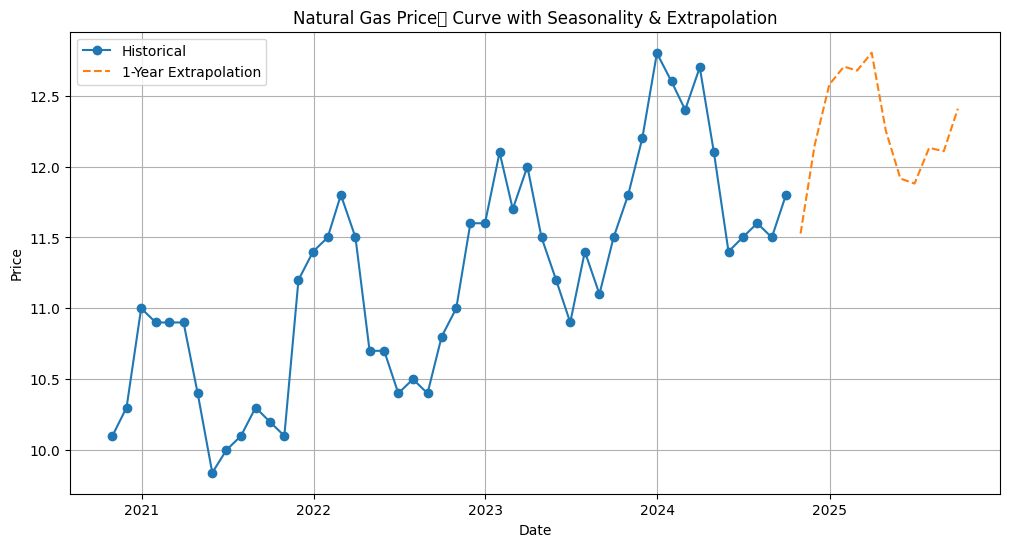

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df["date"], df["price"], label="Historical", marker="o")
plt.plot(future_df["date"], future_df["price"], 
         label="1-Year Extrapolation", linestyle="--")

plt.title("Natural Gas Priceං Curve with Seasonality & Extrapolation")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
print("Price on 2021-12-15:", estimate_gas_price("2021-12-15"))
print("Price on 2024-06-10:", estimate_gas_price("2024-06-10"))
print("Price on 2025-03-15:", estimate_gas_price("2025-03-15"))


Price on 2021-12-15: 11.49
Price on 2024-06-10: 11.377
Price on 2025-03-15: 12.777


In [15]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the data from file
df = pd.read_csv('/workspaces/Generative-AI/Nat_Gas.csv', header=0)
df.columns = ['raw']

# Parse function for the concatenated date-price format
def parse_row(raw):
    s = str(int(raw))
    # Extract year (first 4 digits)
    year = int(s[:4])
    # Find price start (last 4-5 chars before E notation if present, but since read as float then int, handle as string)
    # Price is last part after date
    # Trial shows date len varies 6-7 chars after year
    if len(s) <= 8:
        if len(s) == 8:
            date_str = s[:6]
            price_str = s[6:]
        else:
            date_str = s[:5]
            price_str = s[5:]
    else:
        # For longer, assume date 7 chars
        date_str = s[:-4]
        price_str = s[-4:]
    
    # Parse date
    if len(date_str) == 6:
        month = int(date_str[4:])
        day = 1  # Assume end of month ~ last day, but simplify to 1 for monthly
    elif len(date_str) == 5:
        month = int(date_str[4:])
        day = 1
    else:
        month = int(date_str[-1:])
        day = 1
    
    # Price
    price = float(price_str) / 100  # Since 1.01E01 -> 10.1, but %1000 /100
    
    try:
        date = datetime(year, month, day)
    except:
        date = None
    
    return pd.Series({'date'})


ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements